# Library

In [3]:
import os
import io
import nltk
import string
import json
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import tensorflow as tf
import matplotlib.pyplot as plt
# Import tensorflow.keras instead of just keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
# TextVectorization is now in keras.layers.preprocessing
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping # Updated import
from tensorflow.keras.preprocessing.sequence import pad_sequences # Updated import
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, BatchNormalization, LSTM, Dense, GlobalAveragePooling1D, Flatten, Dropout, GRU, Conv1D, MaxPool1D # Updated import

Load dataset

In [4]:
with open('/content/myskincare_intents.json', 'r') as f:
    data = json.load(f)

# Preprosesing

Exxtrak menjadi dataframe

In [5]:
#Extracting tags (intent), patterns (input provided by user) and responses (output provided by the bot) from dataset
def processing_json_dataset(dataset):
  tags = []
  patterns = []
  responses = {}
  for intent in dataset['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['patterns']:
      patterns.append(lines)
      tags.append(intent['tag'])
  return [tags, patterns, responses]

In [6]:
[tags, patterns, responses] = processing_json_dataset(data)

mengonversi data yang sudah diproses (dalam bentuk list patterns dan tags) menjadi sebuah DataFrame

In [7]:
#Converting dataset into named columns patterns and tags respectively
dataset = pd.DataFrame({"patterns": patterns,"tags": tags})

In [8]:
dataset.head()

,patterns,tags
0,Hai,greeting
1,Bagaimana kabarmu?,greeting
2,Apa kabar di sana?,greeting
3,Hei.,greeting
4,Hai,greeting


 mengacak urutan baris

In [9]:
#To return all rows in random order
dataset = dataset.sample(frac=1)

Pembersihan Teks

In [10]:
# Removing Punctuations (Menghilangkan Punktuasi)
dataset['patterns'] = dataset['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
dataset['patterns'] = dataset['patterns'].apply(lambda wrd: ''.join(wrd))

In [11]:
#Returning first five rows of dataset
dataset['patterns']

,patterns
12,sampai jumpa
15,itu sangat membantu
79,produk cerave untuk kulit berminyak
62,perhatian utama saya adalah itchy skin
14,terima kasih
...,...
61,eksim
38,serum berbagi
120,kosong
18,bagaimana kau bisa membantuku


Penyatuan teks

In [12]:
#Joining the lowercase letters into words again
dataset['patterns'] = dataset['patterns'].apply(lambda word: ''.join(word))

Tokenisasi

In [13]:
#The ids for most frequent 1000 words would be returned.
tokenizer = Tokenizer(num_words=1000)

#An index based vocabulary would be created based on the word frequency.
tokenizer.fit_on_texts(dataset['patterns'])

#It basically takes each word in the text and replaces it with its corresponding integer value from the vocabulary made in the previous step.
train = tokenizer.texts_to_sequences(dataset['patterns'])

#It will pad with 0 the shorter sequences to make sure all sequences have same length
features = pad_sequences(train)

#It takes a categorical column and converts/maps it to numerical values.
labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(dataset['tags'])

memeriksa dimensi data

In [14]:
#Checking shape of our patterns data
input_shape = features.shape[1]
features.shape

(150, 10)

menghitung jumlah kata unik dan panjang output.

In [15]:
#Calculating total unique words in dataset
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ",vocabulary)
output_length = labelEncoder.classes_.shape[0]
print("Output length: ",output_length)

Number of unique words:  201
Output length:  52


 memeriksa vocabulary

In [16]:
#Checking our word vocabulary of most occuring words in pattern
tokenizer.word_index

{'produk': 1,
 'kulit': 2,
 'yang': 3,
 'untuk': 4,
 'sarankan': 5,
 'dengan': 6,
 'saya': 7,
 'tersedia': 8,
 'berbagi': 9,
 'anda': 10,
 'dapatkah': 11,
 'baik': 12,
 'adalah': 13,
 'kering': 14,
 'rutin': 15,
 'cerave': 16,
 'perhatian': 17,
 'utama': 18,
 'aku': 19,
 'berminyak': 20,
 'membagikan': 21,
 'punya': 22,
 'tubuh': 23,
 'merekomendasikan': 24,
 'beberapa': 25,
 'kombinasi': 26,
 'membantu': 27,
 'skin': 28,
 'terima': 29,
 'kasih': 30,
 'perawatan': 31,
 'di': 32,
 'ada': 33,
 'pembersih': 34,
 'wajah': 35,
 'makeup': 36,
 'bagaimana': 37,
 'skincare': 38,
 'tidak': 39,
 'apa': 40,
 'sensitif': 41,
 'krim': 42,
 'serave': 43,
 'asam': 44,
 'mata': 45,
 '562b78': 46,
 'bayi': 47,
 'serum': 48,
 'kau': 49,
 'sampai': 50,
 'sangat': 51,
 'penghapus': 52,
 'jengkel': 53,
 'selamat': 54,
 'tip': 55,
 'baru': 56,
 'dan': 57,
 'hai': 58,
 'dry': 59,
 'reduce': 60,
 'psoriasis': 61,
 'dimana': 62,
 'id': 63,
 'produkproduk': 64,
 'penuaan': 65,
 'bye': 66,
 'moisturizer': 67,
 '

# MODEL LSTM

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dropout, LSTM, BatchNormalization, Dense
import tensorflow as tf


Mengunduh dan Mengekstrak Model GloVe



> GloVe ini digunakan untuk mengambil representasi kata dalam bentuk vektor berdimensi tinggi



In [21]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-01-22 13:10:51--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-22 13:10:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2025-01-22 13:13:30 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

Membangun Arsitektur Model LSTM

In [22]:
# Creating a linear stack of layers
model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Embedding(input_dim=vocabulary+1, output_dim=100))
model.add(Dropout(0.3))

# LSTM layer to process sequences while maintaining context
model.add(LSTM(64, return_sequences=False))  # Set return_sequences=True if you need the full sequence output
model.add(BatchNormalization())
model.add(Dense(128, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.0001)))
model.add(Dense(output_length, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.0001)))

# Model summary to check the architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 100)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 52)                  │           6,708 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,724 (303.61 KB)

 Trainable params: 77,596 (303.11 KB)

 Non-trainable params: 128 (512.00 B)

Memuat dan Menghitung Vektor Kata GloVe.

In [23]:
#Getting glove file and returning the total number of word vectors available
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    word = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = word
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Membuat Matriks Embedding dengan GloVe

In [24]:
#Creating embedding matrix to assign weights to the embedding layer
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Menetapkan Bobot dan Menandai Lapisan Embedding sebagai Non-Trainable.

In [25]:
#Setting weights of embedding layer and specifying it as non-trainable
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Menyusun Model dengan Loss, Optimizer, dan Metrik Evaluasi.

In [26]:
#Compiling the model by specifying loss as sparse_categorical_crossentropy and optimizer as adam
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

Mengatur Callback EarlyStopping

In [27]:
#This callback will stop the training when there is no improvement in the loss for forty consecutive epochs.
early_stopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

Melatih model

In [28]:
#Train for 2000 epochs with batch size of 64.
history_training = model.fit(features, labels, epochs=200, batch_size=64, callbacks=[early_stopping])

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.0000e+00 - loss: 4.3822
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0487 - loss: 4.1038
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0521 - loss: 4.0150
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1008 - loss: 3.8003
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1450 - loss: 3.6261
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1890 - loss: 3.5429
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2653 - loss: 3.3842
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3337 - loss: 3.2514 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3636 - loss: 3.1197
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4059 - loss: 3.0525
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4591 - loss: 2.9821
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4270

In [29]:
model.save('chatbot_skincare_model.h5', history_training)

In [36]:
accuracy = history_training.history['accuracy']
last_accuracy = accuracy[-1]
formatted_accuracy = "{:.2f}".format(last_accuracy)

print(f"Nilai akurasi: {formatted_accuracy}")

Nilai akurasi: 0.84


In [30]:
print(f"Final loss: {history_training.history['loss'][-1]}")

Final loss: 0.7603739500045776


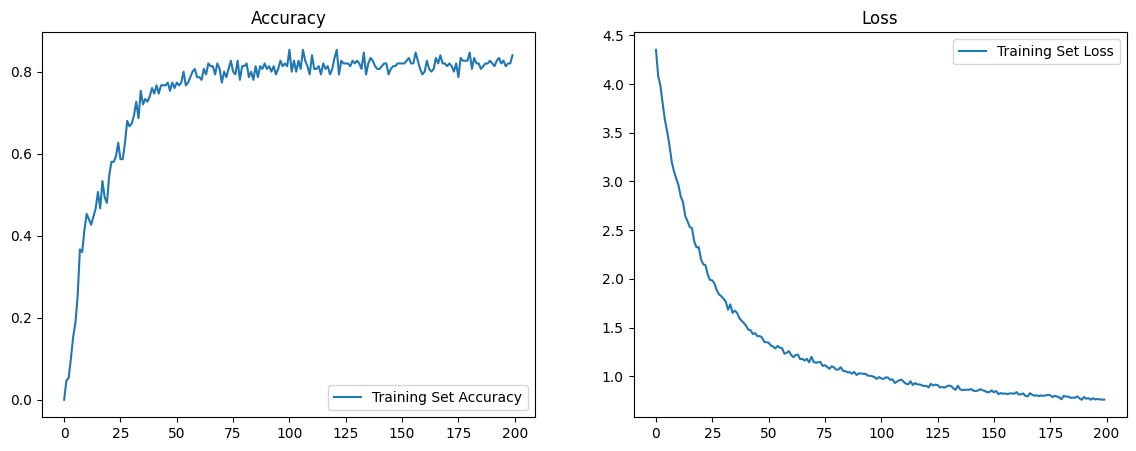

In [31]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_training.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_training.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Testing model

In [61]:
import string
import random
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loop percakapan chatbot
while True:
    texts_p = []
    # Input dari pengguna
    prediction_input = input('👩‍🦰 Kamu : ')

    # Hapus tanda baca dan ubah ke huruf kecil
    prediction_input = ''.join([letters.lower() for letters in prediction_input if letters not in string.punctuation])
    texts_p.append(prediction_input)

    # Tokenisasi dan padding pada teks input
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], maxlen=input_shape)

    # Prediksi output dari model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Menentukan tag respons dan respons acak dari tag tersebut
    # Use labelEncoder instead of le
    response_tag = labelEncoder.inverse_transform([output])[0]
    response_text = random.choice(responses[response_tag])
    print("💅 AskFifi : ", response_text)

    print("=" * 60 + "\n")

    # Menghentikan percakapan jika respons 'goodbye' terdeteksi
    if response_tag == "goodbye":
        print("💅 AskFifi : Sampai jumpa!")
        break

👩‍🦰 Kamu : halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
💅 AskFifi :  Hai, ada yang bisa kubantu?

👩‍🦰 Kamu : rekomendasi krim kulit berjerawat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
💅 AskFifi :  -Rewning SA Cleanser -SA Cream for Rough & Bumpy Skin -SA Lotion for Rough & Bumpy Skin -SA Cleanser Bar for Rough & Bumpy Skin -SA Body Wash for Rough & Bumpy Skin

👩‍🦰 Kamu : terimakasih
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
💅 AskFifi :  Sampai jumpa!

💅 AskFifi : Sampai jumpa!
